In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter


import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

W0924 05:43:47.512440 140702397658944 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0924 05:43:47.514385 140702397658944 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0924 05:43:47.520401 140702397658944 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [3]:
path = '/home/ricardo/TCC/'
df = pd.read_csv(path+'train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']

In [4]:
meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

In [5]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X_norm.loc[fraud_index]
honest = X_norm.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

In [6]:
h_used, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)
x_used = pd.concat([h_used,fraud],ignore_index = False)
y_used = pd.concat([yh,yf],ignore_index=False)
x_train,x_test,y_train,y_test = train_test_split(x_used,y_used,test_size=0.3,random_state = 30)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state = 30)

In [7]:
x_data = [x_train,x_val,x_test]
y_data = [y_train,y_val,y_test]

In [8]:
print('Size of Train Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[0]),Counter(y_data[0])))
print('Size of val Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[1]),Counter(y_data[1])))
print('Size of test Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[2]),Counter(y_data[2])))

Size of Train Data: 45551, not anomalys/anomaly:Counter({0: 31412, 1: 14139})
Size of val Data: 9761, not anomalys/anomaly:Counter({0: 6779, 1: 2982})
Size of test Data: 9761, not anomalys/anomaly:Counter({0: 6784, 1: 2977})


In [9]:
def f1Score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [11]:
def choosing_threshold(y_true,y_prob,threshold_list):
    y_hat = []
    precision = []
    recall = []
    f1 = []
    y_h = []
    for threshold in threshold_list:
        for i in range(len(y_true)):
            if y_prob[i]>threshold:
                y_hat.append(1)
            else:
                y_hat.append(0)
        precision.append(precision_score(y_true,y_hat))
        recall.append(recall_score(y_true,y_hat))
        f1.append(f1_score(y_true,y_hat))
        y_h.append(y_hat)
        y_hat = []
    return(precision,recall,f1,y_h)           

In [12]:
model = models.Sequential()
model.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,),kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))
model.summary()

W0924 05:43:57.642446 140702397658944 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0924 05:43:57.647611 140702397658944 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0924 05:43:57.701341 140702397658944 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


In [13]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

W0924 05:43:57.758046 140702397658944 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0924 05:43:57.776268 140702397658944 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


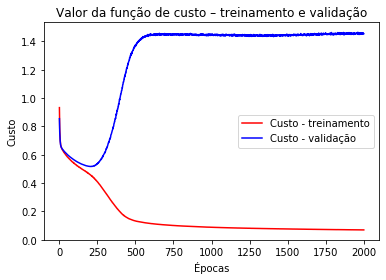

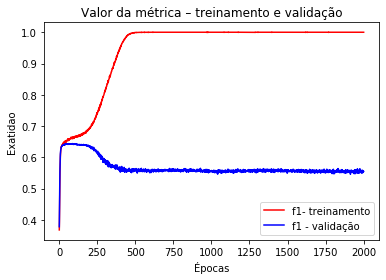

In [14]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [15]:
prob = np.ravel(model.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.990195391834162, 0.9978827016726657, 0.999575821845175, 0.99992927864215, 0.99992927864215, 0.99992927864215, 0.99992927864215, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999292736402857, 0.9998585472805714, 0.9995756418417144, 0.9992927364028573, 0.9969587665322865, 0.9848645590211472, 0.9204328453214513]
f1 values: [0.9950735449363081, 0.9989402289105553, 0.9997878659312686, 0.9999646380706531, 0.9999646380706531, 0.9999646380706531, 0.9999646380706531, 1.0, 1.0, 1.0, 1.0, 0.9999646355695441, 0.9999292686377139, 0.9997877758913413, 0.9996462431017404, 0.9984770674694528, 0.9923745724059294, 0.9585681140205502]


Normalized confusion matrix
[[0.9955431 0.0044569]
 [0.        1.       ]]
Normalized confusion matrix
[[9.99044951e-01 9.55049026e-04]
 [0.00000000e+00 1.00000000e+00]]
Normalized confusion matrix
[[9.99808990e-01 1.91009805e-04]
 [0.00000000e+00 1.00000000e+00]]
Normalized confusion matrix
[[9.99968165e-01 3.18349675e-05]
 [0.00000000e+00 1.00000000e+00]]
Normalized confusion matrix
[[9.99968165e-01 3.18349675e-05]
 [0.00000000e+00 1.00000000e+00]]
Normalized confusion matrix
[[9.99968165e-01 3.18349675e-05]
 [0.00000000e+00 1.00000000e+00]]
Normalized confusion matrix
[[9.99968165e-01 3.18349675e-05]
 [0.00000000e+00 1.00000000e+00]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00]
 [7.07263597e-05 9.99929274e-01]]
Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00]
 [1.4145271

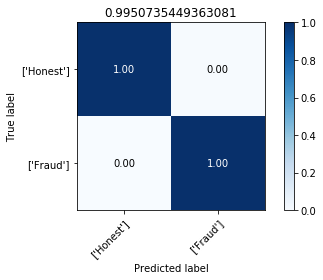

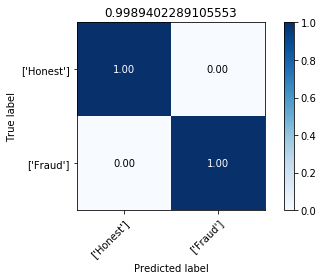

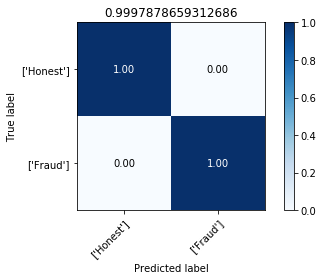

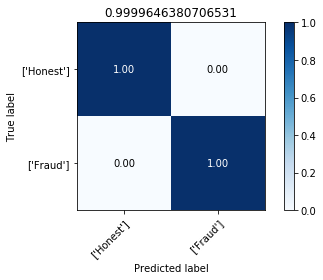

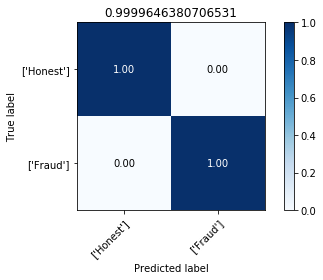

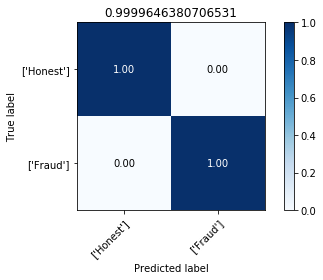

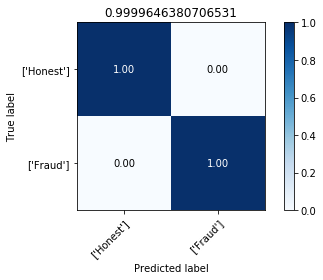

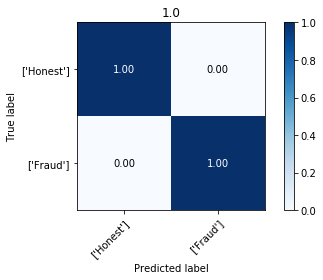

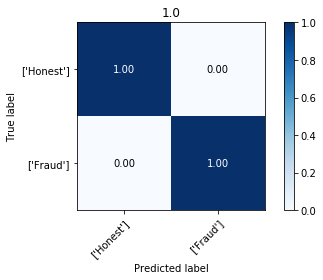

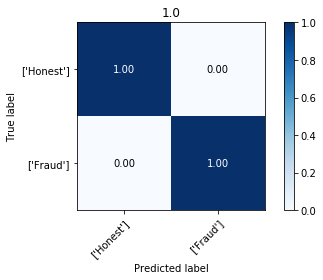

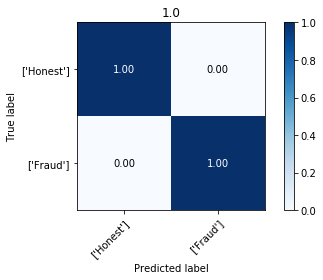

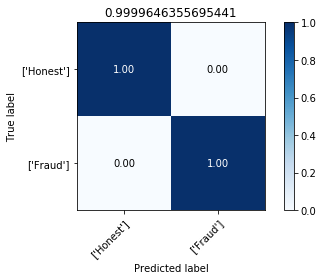

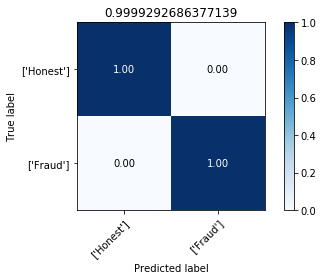

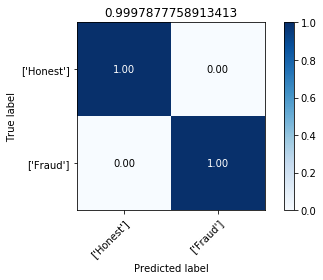

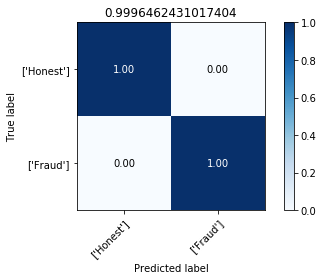

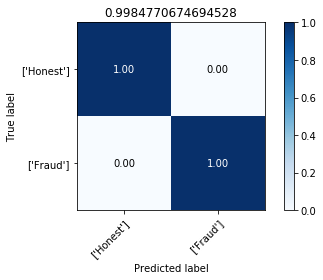

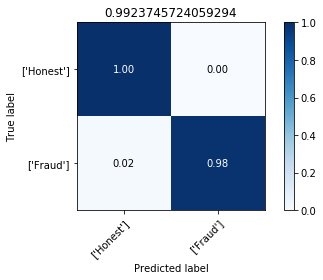

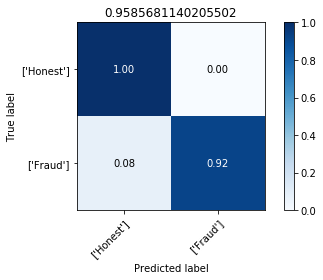

In [16]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [17]:
K.clear_session()

In [18]:
model1 = models.Sequential()
model1.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model1.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(units = 1,activation = 'sigmoid'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


In [19]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model1.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model1.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val))

Train on 45551 samples, validate on 9761 samples
Epoch 1/2000
45551/45551 [==============================] - 2s 48us/step - loss: 0.7649 - f1Score: 0.4353 - val_loss: 0.6919 - val_f1Score: 0.4496
Epoch 2/2000
45551/45551 [==============================] - 2s 43us/step - loss: 0.6850 - f1Score: 0.4489 - val_loss: 0.6418 - val_f1Score: 0.4534
Epoch 3/2000
45551/45551 [==============================] - 2s 46us/step - loss: 0.6411 - f1Score: 0.4807 - val_loss: 0.6106 - val_f1Score: 0.4973
Epoch 4/2000
45551/45551 [==============================] - 2s 41us/step - loss: 0.6127 - f1Score: 0.5140 - val_loss: 0.5875 - val_f1Score: 0.5321
Epoch 5/2000
45551/45551 [==============================] - 2s 41us/step - loss: 0.5897 - f1Score: 0.5512 - val_loss: 0.5702 - val_f1Score: 0.5653
Epoch 6/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.5740 - f1Score: 0.5745 - val_loss: 0.5576 - val_f1Score: 0.5820
Epoch 7/2000
45551/45551 [==============================] - 2s 40us/s

45551/45551 [==============================] - 2s 39us/step - loss: 0.4868 - f1Score: 0.6544 - val_loss: 0.5066 - val_f1Score: 0.6368
Epoch 57/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.4860 - f1Score: 0.6571 - val_loss: 0.5062 - val_f1Score: 0.6371
Epoch 58/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.4868 - f1Score: 0.6558 - val_loss: 0.5058 - val_f1Score: 0.6371
Epoch 59/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.4853 - f1Score: 0.6563 - val_loss: 0.5054 - val_f1Score: 0.6362
Epoch 60/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.4836 - f1Score: 0.6553 - val_loss: 0.5050 - val_f1Score: 0.6364
Epoch 61/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.4827 - f1Score: 0.6578 - val_loss: 0.5046 - val_f1Score: 0.6371
Epoch 62/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.4824 - f1Score: 0.6560 - val_loss: 0.5042 

45551/45551 [==============================] - 2s 40us/step - loss: 0.4540 - f1Score: 0.6699 - val_loss: 0.4882 - val_f1Score: 0.6390
Epoch 112/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.4550 - f1Score: 0.6711 - val_loss: 0.4879 - val_f1Score: 0.6385
Epoch 113/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.4543 - f1Score: 0.6716 - val_loss: 0.4876 - val_f1Score: 0.6384
Epoch 114/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.4543 - f1Score: 0.6692 - val_loss: 0.4873 - val_f1Score: 0.6389
Epoch 115/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.4540 - f1Score: 0.6702 - val_loss: 0.4870 - val_f1Score: 0.6394
Epoch 116/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.4529 - f1Score: 0.6711 - val_loss: 0.4868 - val_f1Score: 0.6385
Epoch 117/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.4526 - f1Score: 0.6694 - val_loss: 0

45551/45551 [==============================] - 2s 40us/step - loss: 0.4269 - f1Score: 0.6869 - val_loss: 0.4780 - val_f1Score: 0.6386
Epoch 167/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.4265 - f1Score: 0.6850 - val_loss: 0.4779 - val_f1Score: 0.6381
Epoch 168/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.4263 - f1Score: 0.6871 - val_loss: 0.4778 - val_f1Score: 0.6380
Epoch 169/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.4261 - f1Score: 0.6815 - val_loss: 0.4778 - val_f1Score: 0.6372
Epoch 170/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.4258 - f1Score: 0.6862 - val_loss: 0.4777 - val_f1Score: 0.6384
Epoch 171/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.4253 - f1Score: 0.6863 - val_loss: 0.4776 - val_f1Score: 0.6376
Epoch 172/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.4239 - f1Score: 0.6859 - val_loss: 0

45551/45551 [==============================] - 2s 39us/step - loss: 0.3927 - f1Score: 0.7103 - val_loss: 0.4847 - val_f1Score: 0.6286
Epoch 222/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.3919 - f1Score: 0.7111 - val_loss: 0.4849 - val_f1Score: 0.6277
Epoch 223/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.3906 - f1Score: 0.7146 - val_loss: 0.4854 - val_f1Score: 0.6284
Epoch 224/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.3898 - f1Score: 0.7139 - val_loss: 0.4859 - val_f1Score: 0.6287
Epoch 225/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.3893 - f1Score: 0.7152 - val_loss: 0.4862 - val_f1Score: 0.6293
Epoch 226/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.3888 - f1Score: 0.7160 - val_loss: 0.4868 - val_f1Score: 0.6284
Epoch 227/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.3871 - f1Score: 0.7162 - val_loss: 0

45551/45551 [==============================] - 2s 40us/step - loss: 0.3394 - f1Score: 0.7612 - val_loss: 0.5337 - val_f1Score: 0.6067
Epoch 277/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.3387 - f1Score: 0.7620 - val_loss: 0.5356 - val_f1Score: 0.6060
Epoch 278/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.3355 - f1Score: 0.7691 - val_loss: 0.5375 - val_f1Score: 0.6057
Epoch 279/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.3358 - f1Score: 0.7649 - val_loss: 0.5383 - val_f1Score: 0.6046
Epoch 280/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.3346 - f1Score: 0.7674 - val_loss: 0.5403 - val_f1Score: 0.6016
Epoch 281/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.3336 - f1Score: 0.7649 - val_loss: 0.5417 - val_f1Score: 0.6043
Epoch 282/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.3319 - f1Score: 0.7680 - val_loss: 0

45551/45551 [==============================] - 2s 40us/step - loss: 0.2694 - f1Score: 0.8251 - val_loss: 0.6451 - val_f1Score: 0.5832
Epoch 332/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.2678 - f1Score: 0.8279 - val_loss: 0.6477 - val_f1Score: 0.5811
Epoch 333/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.2678 - f1Score: 0.8253 - val_loss: 0.6499 - val_f1Score: 0.5800
Epoch 334/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.2659 - f1Score: 0.8292 - val_loss: 0.6510 - val_f1Score: 0.5810
Epoch 335/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.2634 - f1Score: 0.8289 - val_loss: 0.6534 - val_f1Score: 0.5788
Epoch 336/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.2631 - f1Score: 0.8302 - val_loss: 0.6569 - val_f1Score: 0.5788
Epoch 337/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.2612 - f1Score: 0.8324 - val_loss: 0

45551/45551 [==============================] - 2s 40us/step - loss: 0.1893 - f1Score: 0.8937 - val_loss: 0.8505 - val_f1Score: 0.5611
Epoch 387/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.1883 - f1Score: 0.8963 - val_loss: 0.8570 - val_f1Score: 0.5626
Epoch 388/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.1862 - f1Score: 0.8954 - val_loss: 0.8687 - val_f1Score: 0.5640
Epoch 389/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.1852 - f1Score: 0.8955 - val_loss: 0.8720 - val_f1Score: 0.5636
Epoch 390/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.1833 - f1Score: 0.8971 - val_loss: 0.8779 - val_f1Score: 0.5619
Epoch 391/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.1821 - f1Score: 0.8999 - val_loss: 0.8831 - val_f1Score: 0.5622
Epoch 392/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.1799 - f1Score: 0.9001 - val_loss: 0

45551/45551 [==============================] - 2s 40us/step - loss: 0.1101 - f1Score: 0.9598 - val_loss: 1.2235 - val_f1Score: 0.5490
Epoch 442/2000
45551/45551 [==============================] - 2s 39us/step - loss: 0.1086 - f1Score: 0.9632 - val_loss: 1.2331 - val_f1Score: 0.5466
Epoch 443/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.1076 - f1Score: 0.9628 - val_loss: 1.2400 - val_f1Score: 0.5464
Epoch 444/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.1067 - f1Score: 0.9639 - val_loss: 1.2451 - val_f1Score: 0.5462
Epoch 445/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.1051 - f1Score: 0.9648 - val_loss: 1.2549 - val_f1Score: 0.5450
Epoch 446/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.1039 - f1Score: 0.9678 - val_loss: 1.2628 - val_f1Score: 0.5454
Epoch 447/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.1024 - f1Score: 0.9683 - val_loss: 1

45551/45551 [==============================] - 2s 40us/step - loss: 0.0603 - f1Score: 0.9988 - val_loss: 1.6302 - val_f1Score: 0.5427
Epoch 497/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0598 - f1Score: 0.9987 - val_loss: 1.6357 - val_f1Score: 0.5421
Epoch 498/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0593 - f1Score: 0.9987 - val_loss: 1.6448 - val_f1Score: 0.5405
Epoch 499/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0587 - f1Score: 0.9989 - val_loss: 1.6489 - val_f1Score: 0.5457
Epoch 500/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0581 - f1Score: 0.9994 - val_loss: 1.6534 - val_f1Score: 0.5466
Epoch 501/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0576 - f1Score: 0.9993 - val_loss: 1.6583 - val_f1Score: 0.5430
Epoch 502/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0574 - f1Score: 0.9993 - val_loss: 1

45551/45551 [==============================] - 2s 40us/step - loss: 0.0429 - f1Score: 1.0000 - val_loss: 1.8582 - val_f1Score: 0.5425
Epoch 552/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0426 - f1Score: 1.0000 - val_loss: 1.8615 - val_f1Score: 0.5430
Epoch 553/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0426 - f1Score: 1.0000 - val_loss: 1.8671 - val_f1Score: 0.5424
Epoch 554/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0424 - f1Score: 1.0000 - val_loss: 1.8644 - val_f1Score: 0.5421
Epoch 555/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0421 - f1Score: 1.0000 - val_loss: 1.8693 - val_f1Score: 0.5431
Epoch 556/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0419 - f1Score: 1.0000 - val_loss: 1.8709 - val_f1Score: 0.5420
Epoch 557/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0418 - f1Score: 1.0000 - val_loss: 1

45551/45551 [==============================] - 2s 40us/step - loss: 0.0356 - f1Score: 1.0000 - val_loss: 1.9580 - val_f1Score: 0.5423
Epoch 607/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0355 - f1Score: 1.0000 - val_loss: 1.9592 - val_f1Score: 0.5433
Epoch 608/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0354 - f1Score: 1.0000 - val_loss: 1.9614 - val_f1Score: 0.5414
Epoch 609/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0353 - f1Score: 0.9997 - val_loss: 1.9626 - val_f1Score: 0.5416
Epoch 610/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0351 - f1Score: 1.0000 - val_loss: 1.9625 - val_f1Score: 0.5423
Epoch 611/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0351 - f1Score: 1.0000 - val_loss: 1.9644 - val_f1Score: 0.5405
Epoch 612/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0349 - f1Score: 1.0000 - val_loss: 1

45551/45551 [==============================] - 2s 40us/step - loss: 0.0311 - f1Score: 1.0000 - val_loss: 2.0003 - val_f1Score: 0.5428
Epoch 662/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0311 - f1Score: 1.0000 - val_loss: 2.0002 - val_f1Score: 0.5417
Epoch 663/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0310 - f1Score: 1.0000 - val_loss: 2.0019 - val_f1Score: 0.5428
Epoch 664/2000
45551/45551 [==============================] - 2s 42us/step - loss: 0.0309 - f1Score: 1.0000 - val_loss: 2.0023 - val_f1Score: 0.5440
Epoch 665/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0308 - f1Score: 1.0000 - val_loss: 2.0019 - val_f1Score: 0.5426
Epoch 666/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0308 - f1Score: 1.0000 - val_loss: 2.0024 - val_f1Score: 0.5413
Epoch 667/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0307 - f1Score: 1.0000 - val_loss: 2

45551/45551 [==============================] - 2s 40us/step - loss: 0.0279 - f1Score: 1.0000 - val_loss: 2.0156 - val_f1Score: 0.5404
Epoch 717/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0278 - f1Score: 1.0000 - val_loss: 2.0162 - val_f1Score: 0.5412
Epoch 718/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0278 - f1Score: 1.0000 - val_loss: 2.0162 - val_f1Score: 0.5412
Epoch 719/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0277 - f1Score: 1.0000 - val_loss: 2.0157 - val_f1Score: 0.5408
Epoch 720/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0277 - f1Score: 1.0000 - val_loss: 2.0162 - val_f1Score: 0.5411
Epoch 721/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0277 - f1Score: 1.0000 - val_loss: 2.0166 - val_f1Score: 0.5409
Epoch 722/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0276 - f1Score: 1.0000 - val_loss: 2

Epoch 771/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0254 - f1Score: 1.0000 - val_loss: 2.0211 - val_f1Score: 0.5419
Epoch 772/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0254 - f1Score: 1.0000 - val_loss: 2.0217 - val_f1Score: 0.5402
Epoch 773/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0253 - f1Score: 1.0000 - val_loss: 2.0210 - val_f1Score: 0.5405
Epoch 774/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0253 - f1Score: 1.0000 - val_loss: 2.0219 - val_f1Score: 0.5403
Epoch 775/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0253 - f1Score: 1.0000 - val_loss: 2.0219 - val_f1Score: 0.5421
Epoch 776/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0252 - f1Score: 1.0000 - val_loss: 2.0221 - val_f1Score: 0.5401
Epoch 777/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0252 - f1Score: 1.000

Epoch 826/2000
45551/45551 [==============================] - 2s 42us/step - loss: 0.0234 - f1Score: 1.0000 - val_loss: 2.0218 - val_f1Score: 0.5395
Epoch 827/2000
45551/45551 [==============================] - 2s 41us/step - loss: 0.0234 - f1Score: 1.0000 - val_loss: 2.0209 - val_f1Score: 0.5393
Epoch 828/2000
45551/45551 [==============================] - 2s 43us/step - loss: 0.0234 - f1Score: 1.0000 - val_loss: 2.0217 - val_f1Score: 0.5396
Epoch 829/2000
45551/45551 [==============================] - 2s 45us/step - loss: 0.0233 - f1Score: 1.0000 - val_loss: 2.0210 - val_f1Score: 0.5391
Epoch 830/2000
45551/45551 [==============================] - 2s 41us/step - loss: 0.0233 - f1Score: 1.0000 - val_loss: 2.0216 - val_f1Score: 0.5393
Epoch 831/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0232 - f1Score: 1.0000 - val_loss: 2.0214 - val_f1Score: 0.5390
Epoch 832/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0232 - f1Score: 1.000

Epoch 881/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0218 - f1Score: 1.0000 - val_loss: 2.0208 - val_f1Score: 0.5398
Epoch 882/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0217 - f1Score: 1.0000 - val_loss: 2.0196 - val_f1Score: 0.5402
Epoch 883/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0217 - f1Score: 1.0000 - val_loss: 2.0195 - val_f1Score: 0.5406
Epoch 884/2000
45551/45551 [==============================] - 2s 41us/step - loss: 0.0217 - f1Score: 1.0000 - val_loss: 2.0210 - val_f1Score: 0.5402
Epoch 885/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0216 - f1Score: 1.0000 - val_loss: 2.0200 - val_f1Score: 0.5398
Epoch 886/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0216 - f1Score: 1.0000 - val_loss: 2.0203 - val_f1Score: 0.5402
Epoch 887/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0216 - f1Score: 1.000

Epoch 936/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0204 - f1Score: 1.0000 - val_loss: 2.0194 - val_f1Score: 0.5411
Epoch 937/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0204 - f1Score: 1.0000 - val_loss: 2.0189 - val_f1Score: 0.5423
Epoch 938/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0204 - f1Score: 1.0000 - val_loss: 2.0184 - val_f1Score: 0.5409
Epoch 939/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0204 - f1Score: 1.0000 - val_loss: 2.0187 - val_f1Score: 0.5406
Epoch 940/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0203 - f1Score: 1.0000 - val_loss: 2.0187 - val_f1Score: 0.5413
Epoch 941/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0203 - f1Score: 1.0000 - val_loss: 2.0196 - val_f1Score: 0.5420
Epoch 942/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0203 - f1Score: 1.000

Epoch 991/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0192 - f1Score: 1.0000 - val_loss: 2.0176 - val_f1Score: 0.5407
Epoch 992/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0192 - f1Score: 1.0000 - val_loss: 2.0172 - val_f1Score: 0.5418
Epoch 993/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0192 - f1Score: 1.0000 - val_loss: 2.0175 - val_f1Score: 0.5419
Epoch 994/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0192 - f1Score: 1.0000 - val_loss: 2.0165 - val_f1Score: 0.5428
Epoch 995/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0192 - f1Score: 1.0000 - val_loss: 2.0172 - val_f1Score: 0.5412
Epoch 996/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0192 - f1Score: 1.0000 - val_loss: 2.0167 - val_f1Score: 0.5421
Epoch 997/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0192 - f1Score: 1.000

45551/45551 [==============================] - 2s 40us/step - loss: 0.0183 - f1Score: 1.0000 - val_loss: 2.0158 - val_f1Score: 0.5430
Epoch 1046/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0183 - f1Score: 1.0000 - val_loss: 2.0157 - val_f1Score: 0.5420
Epoch 1047/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0183 - f1Score: 1.0000 - val_loss: 2.0164 - val_f1Score: 0.5433
Epoch 1048/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0182 - f1Score: 1.0000 - val_loss: 2.0165 - val_f1Score: 0.5425
Epoch 1049/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0182 - f1Score: 1.0000 - val_loss: 2.0159 - val_f1Score: 0.5433
Epoch 1050/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0182 - f1Score: 1.0000 - val_loss: 2.0162 - val_f1Score: 0.5427
Epoch 1051/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0182 - f1Score: 1.0000 - val_l

Epoch 1100/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0174 - f1Score: 1.0000 - val_loss: 2.0157 - val_f1Score: 0.5438
Epoch 1101/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0174 - f1Score: 1.0000 - val_loss: 2.0157 - val_f1Score: 0.5437
Epoch 1102/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0174 - f1Score: 1.0000 - val_loss: 2.0161 - val_f1Score: 0.5439
Epoch 1103/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0174 - f1Score: 1.0000 - val_loss: 2.0157 - val_f1Score: 0.5433
Epoch 1104/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0173 - f1Score: 1.0000 - val_loss: 2.0156 - val_f1Score: 0.5431
Epoch 1105/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0173 - f1Score: 1.0000 - val_loss: 2.0157 - val_f1Score: 0.5441
Epoch 1106/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0173 - f1Score

45551/45551 [==============================] - 2s 40us/step - loss: 0.0167 - f1Score: 1.0000 - val_loss: 2.0156 - val_f1Score: 0.5434
Epoch 1155/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0166 - f1Score: 1.0000 - val_loss: 2.0153 - val_f1Score: 0.5432
Epoch 1156/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0166 - f1Score: 1.0000 - val_loss: 2.0154 - val_f1Score: 0.5435
Epoch 1157/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0166 - f1Score: 1.0000 - val_loss: 2.0154 - val_f1Score: 0.5438
Epoch 1158/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0166 - f1Score: 1.0000 - val_loss: 2.0150 - val_f1Score: 0.5431
Epoch 1159/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0166 - f1Score: 1.0000 - val_loss: 2.0155 - val_f1Score: 0.5436
Epoch 1160/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0166 - f1Score: 1.0000 - val_l

Epoch 1209/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0159 - f1Score: 1.0000 - val_loss: 2.0158 - val_f1Score: 0.5438
Epoch 1210/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0160 - f1Score: 1.0000 - val_loss: 2.0150 - val_f1Score: 0.5441
Epoch 1211/2000
45551/45551 [==============================] - 2s 41us/step - loss: 0.0160 - f1Score: 1.0000 - val_loss: 2.0160 - val_f1Score: 0.5443
Epoch 1212/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0159 - f1Score: 1.0000 - val_loss: 2.0157 - val_f1Score: 0.5440
Epoch 1213/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0159 - f1Score: 1.0000 - val_loss: 2.0161 - val_f1Score: 0.5437
Epoch 1214/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0159 - f1Score: 1.0000 - val_loss: 2.0156 - val_f1Score: 0.5448
Epoch 1215/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0159 - f1Score

45551/45551 [==============================] - 2s 40us/step - loss: 0.0154 - f1Score: 1.0000 - val_loss: 2.0165 - val_f1Score: 0.5439
Epoch 1264/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0153 - f1Score: 1.0000 - val_loss: 2.0165 - val_f1Score: 0.5435
Epoch 1265/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0154 - f1Score: 1.0000 - val_loss: 2.0172 - val_f1Score: 0.5436
Epoch 1266/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0153 - f1Score: 1.0000 - val_loss: 2.0165 - val_f1Score: 0.5440
Epoch 1267/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0153 - f1Score: 1.0000 - val_loss: 2.0164 - val_f1Score: 0.5444
Epoch 1268/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0153 - f1Score: 1.0000 - val_loss: 2.0166 - val_f1Score: 0.5442
Epoch 1269/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0153 - f1Score: 1.0000 - val_l

Epoch 1318/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0148 - f1Score: 1.0000 - val_loss: 2.0169 - val_f1Score: 0.5436
Epoch 1319/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0148 - f1Score: 1.0000 - val_loss: 2.0172 - val_f1Score: 0.5444
Epoch 1320/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0148 - f1Score: 1.0000 - val_loss: 2.0171 - val_f1Score: 0.5432
Epoch 1321/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0148 - f1Score: 1.0000 - val_loss: 2.0170 - val_f1Score: 0.5433
Epoch 1322/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0148 - f1Score: 1.0000 - val_loss: 2.0173 - val_f1Score: 0.5440
Epoch 1323/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0147 - f1Score: 1.0000 - val_loss: 2.0175 - val_f1Score: 0.5441
Epoch 1324/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0147 - f1Score

45551/45551 [==============================] - 2s 40us/step - loss: 0.0144 - f1Score: 1.0000 - val_loss: 2.0178 - val_f1Score: 0.5444
Epoch 1373/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0143 - f1Score: 1.0000 - val_loss: 2.0180 - val_f1Score: 0.5436
Epoch 1374/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0143 - f1Score: 1.0000 - val_loss: 2.0182 - val_f1Score: 0.5444
Epoch 1375/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0143 - f1Score: 1.0000 - val_loss: 2.0178 - val_f1Score: 0.5435
Epoch 1376/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0143 - f1Score: 1.0000 - val_loss: 2.0179 - val_f1Score: 0.5444
Epoch 1377/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0143 - f1Score: 1.0000 - val_loss: 2.0178 - val_f1Score: 0.5434
Epoch 1378/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0143 - f1Score: 1.0000 - val_l

Epoch 1427/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0139 - f1Score: 1.0000 - val_loss: 2.0186 - val_f1Score: 0.5443
Epoch 1428/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0139 - f1Score: 1.0000 - val_loss: 2.0186 - val_f1Score: 0.5437
Epoch 1429/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0139 - f1Score: 1.0000 - val_loss: 2.0186 - val_f1Score: 0.5439
Epoch 1430/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0138 - f1Score: 1.0000 - val_loss: 2.0187 - val_f1Score: 0.5444
Epoch 1431/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0138 - f1Score: 1.0000 - val_loss: 2.0186 - val_f1Score: 0.5448
Epoch 1432/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0138 - f1Score: 1.0000 - val_loss: 2.0183 - val_f1Score: 0.5444
Epoch 1433/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0138 - f1Score

45551/45551 [==============================] - 2s 41us/step - loss: 0.0135 - f1Score: 1.0000 - val_loss: 2.0190 - val_f1Score: 0.5442
Epoch 1482/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0135 - f1Score: 1.0000 - val_loss: 2.0192 - val_f1Score: 0.5447
Epoch 1483/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0134 - f1Score: 1.0000 - val_loss: 2.0189 - val_f1Score: 0.5445
Epoch 1484/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0135 - f1Score: 1.0000 - val_loss: 2.0193 - val_f1Score: 0.5442
Epoch 1485/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0134 - f1Score: 1.0000 - val_loss: 2.0192 - val_f1Score: 0.5440
Epoch 1486/2000
45551/45551 [==============================] - 2s 42us/step - loss: 0.0134 - f1Score: 1.0000 - val_loss: 2.0192 - val_f1Score: 0.5441
Epoch 1487/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0134 - f1Score: 1.0000 - val_l

Epoch 1536/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0131 - f1Score: 1.0000 - val_loss: 2.0194 - val_f1Score: 0.5441
Epoch 1537/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0131 - f1Score: 1.0000 - val_loss: 2.0194 - val_f1Score: 0.5438
Epoch 1538/2000
45551/45551 [==============================] - 2s 41us/step - loss: 0.0131 - f1Score: 1.0000 - val_loss: 2.0203 - val_f1Score: 0.5437
Epoch 1539/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0131 - f1Score: 1.0000 - val_loss: 2.0200 - val_f1Score: 0.5435
Epoch 1540/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0131 - f1Score: 1.0000 - val_loss: 2.0196 - val_f1Score: 0.5444
Epoch 1541/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0131 - f1Score: 1.0000 - val_loss: 2.0191 - val_f1Score: 0.5443
Epoch 1542/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0131 - f1Score

45551/45551 [==============================] - 2s 40us/step - loss: 0.0127 - f1Score: 1.0000 - val_loss: 2.0206 - val_f1Score: 0.5448
Epoch 1591/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0127 - f1Score: 1.0000 - val_loss: 2.0207 - val_f1Score: 0.5443
Epoch 1592/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0127 - f1Score: 1.0000 - val_loss: 2.0206 - val_f1Score: 0.5444
Epoch 1593/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0127 - f1Score: 1.0000 - val_loss: 2.0209 - val_f1Score: 0.5445
Epoch 1594/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0127 - f1Score: 1.0000 - val_loss: 2.0202 - val_f1Score: 0.5449
Epoch 1595/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0127 - f1Score: 1.0000 - val_loss: 2.0200 - val_f1Score: 0.5444
Epoch 1596/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0127 - f1Score: 1.0000 - val_l

Epoch 1645/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0124 - f1Score: 1.0000 - val_loss: 2.0210 - val_f1Score: 0.5447
Epoch 1646/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0124 - f1Score: 1.0000 - val_loss: 2.0215 - val_f1Score: 0.5446
Epoch 1647/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0124 - f1Score: 1.0000 - val_loss: 2.0219 - val_f1Score: 0.5442
Epoch 1648/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0124 - f1Score: 1.0000 - val_loss: 2.0213 - val_f1Score: 0.5453
Epoch 1649/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0123 - f1Score: 1.0000 - val_loss: 2.0220 - val_f1Score: 0.5447
Epoch 1650/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0124 - f1Score: 1.0000 - val_loss: 2.0216 - val_f1Score: 0.5442
Epoch 1651/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0124 - f1Score

45551/45551 [==============================] - 2s 40us/step - loss: 0.0121 - f1Score: 1.0000 - val_loss: 2.0223 - val_f1Score: 0.5443
Epoch 1700/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0121 - f1Score: 1.0000 - val_loss: 2.0221 - val_f1Score: 0.5440
Epoch 1701/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0121 - f1Score: 1.0000 - val_loss: 2.0222 - val_f1Score: 0.5441
Epoch 1702/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0120 - f1Score: 1.0000 - val_loss: 2.0222 - val_f1Score: 0.5448
Epoch 1703/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0121 - f1Score: 1.0000 - val_loss: 2.0224 - val_f1Score: 0.5443
Epoch 1704/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0121 - f1Score: 1.0000 - val_loss: 2.0221 - val_f1Score: 0.5444
Epoch 1705/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0120 - f1Score: 1.0000 - val_l

Epoch 1754/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0118 - f1Score: 1.0000 - val_loss: 2.0237 - val_f1Score: 0.5438
Epoch 1755/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0118 - f1Score: 1.0000 - val_loss: 2.0234 - val_f1Score: 0.5440
Epoch 1756/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0118 - f1Score: 1.0000 - val_loss: 2.0235 - val_f1Score: 0.5431
Epoch 1757/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0118 - f1Score: 1.0000 - val_loss: 2.0232 - val_f1Score: 0.5434
Epoch 1758/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0118 - f1Score: 1.0000 - val_loss: 2.0232 - val_f1Score: 0.5442
Epoch 1759/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0118 - f1Score: 1.0000 - val_loss: 2.0233 - val_f1Score: 0.5440
Epoch 1760/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0118 - f1Score

45551/45551 [==============================] - 2s 40us/step - loss: 0.0115 - f1Score: 1.0000 - val_loss: 2.0240 - val_f1Score: 0.5439
Epoch 1809/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0115 - f1Score: 1.0000 - val_loss: 2.0241 - val_f1Score: 0.5432
Epoch 1810/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0115 - f1Score: 1.0000 - val_loss: 2.0243 - val_f1Score: 0.5434
Epoch 1811/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0115 - f1Score: 1.0000 - val_loss: 2.0241 - val_f1Score: 0.5433
Epoch 1812/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0115 - f1Score: 1.0000 - val_loss: 2.0249 - val_f1Score: 0.5432
Epoch 1813/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0115 - f1Score: 1.0000 - val_loss: 2.0242 - val_f1Score: 0.5435
Epoch 1814/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0115 - f1Score: 1.0000 - val_l

Epoch 1863/2000
45551/45551 [==============================] - 2s 41us/step - loss: 0.0113 - f1Score: 1.0000 - val_loss: 2.0251 - val_f1Score: 0.5432
Epoch 1864/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0113 - f1Score: 1.0000 - val_loss: 2.0256 - val_f1Score: 0.5432
Epoch 1865/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0113 - f1Score: 1.0000 - val_loss: 2.0251 - val_f1Score: 0.5433
Epoch 1866/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0112 - f1Score: 1.0000 - val_loss: 2.0257 - val_f1Score: 0.5431
Epoch 1867/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0113 - f1Score: 1.0000 - val_loss: 2.0257 - val_f1Score: 0.5436
Epoch 1868/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0112 - f1Score: 1.0000 - val_loss: 2.0253 - val_f1Score: 0.5441
Epoch 1869/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0112 - f1Score

45551/45551 [==============================] - 2s 40us/step - loss: 0.0110 - f1Score: 1.0000 - val_loss: 2.0257 - val_f1Score: 0.5439
Epoch 1918/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0110 - f1Score: 1.0000 - val_loss: 2.0255 - val_f1Score: 0.5437
Epoch 1919/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0110 - f1Score: 1.0000 - val_loss: 2.0259 - val_f1Score: 0.5443
Epoch 1920/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0110 - f1Score: 1.0000 - val_loss: 2.0260 - val_f1Score: 0.5439
Epoch 1921/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0110 - f1Score: 1.0000 - val_loss: 2.0257 - val_f1Score: 0.5440
Epoch 1922/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0110 - f1Score: 1.0000 - val_loss: 2.0260 - val_f1Score: 0.5443
Epoch 1923/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0110 - f1Score: 1.0000 - val_l

Epoch 1972/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0108 - f1Score: 1.0000 - val_loss: 2.0267 - val_f1Score: 0.5437
Epoch 1973/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0108 - f1Score: 1.0000 - val_loss: 2.0271 - val_f1Score: 0.5439
Epoch 1974/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0108 - f1Score: 1.0000 - val_loss: 2.0270 - val_f1Score: 0.5434
Epoch 1975/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0108 - f1Score: 0.9997 - val_loss: 2.0273 - val_f1Score: 0.5442
Epoch 1976/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0108 - f1Score: 1.0000 - val_loss: 2.0274 - val_f1Score: 0.5439
Epoch 1977/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0108 - f1Score: 1.0000 - val_loss: 2.0275 - val_f1Score: 0.5437
Epoch 1978/2000
45551/45551 [==============================] - 2s 40us/step - loss: 0.0108 - f1Score

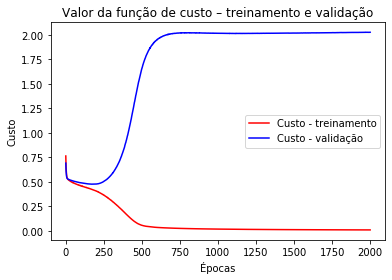

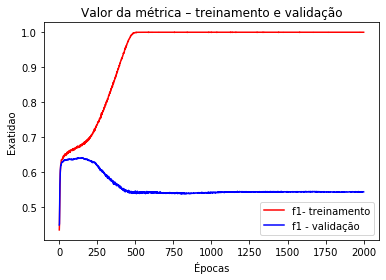

In [20]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [21]:
prob = np.ravel(model1.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
f1 values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


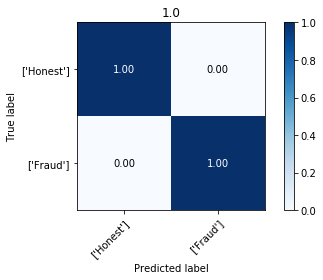

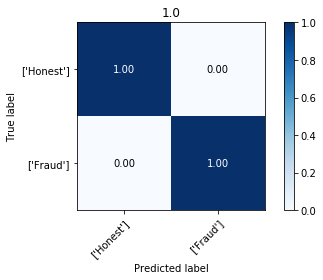

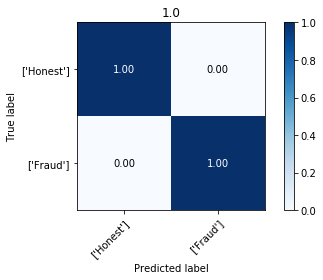

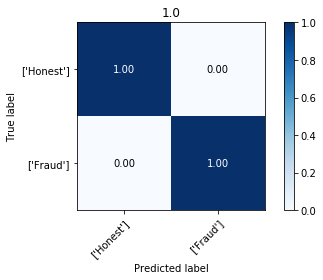

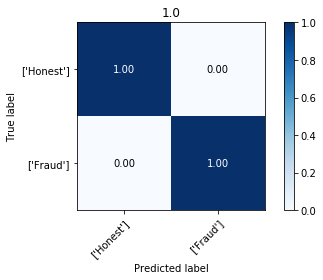

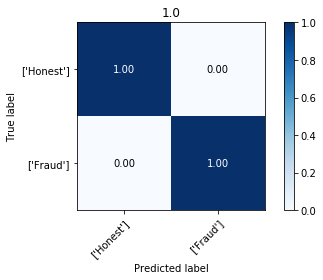

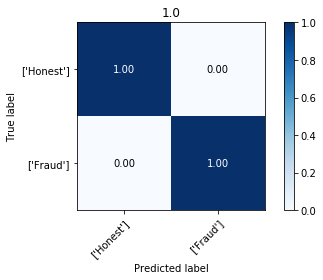

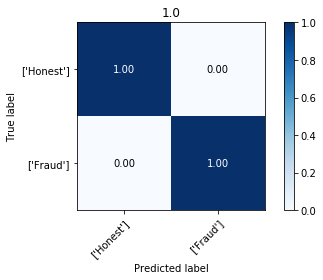

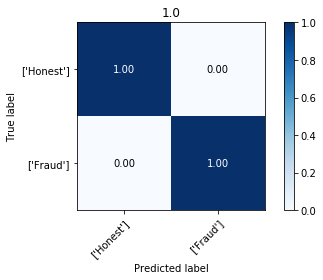

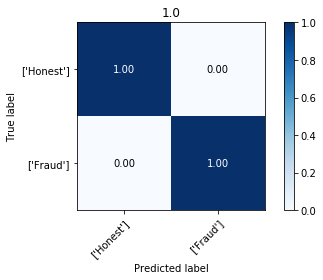

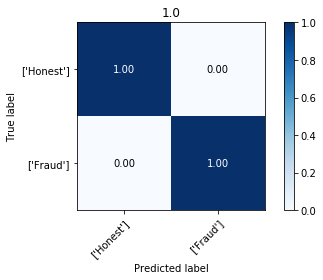

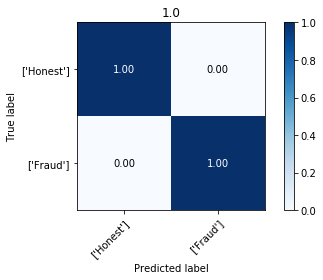

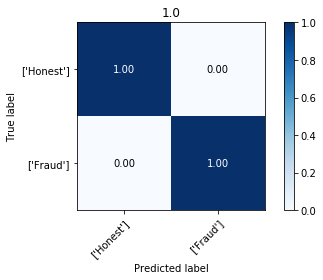

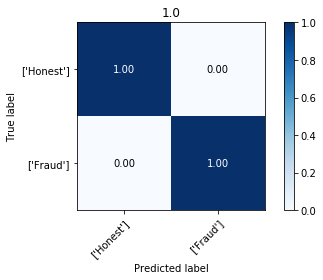

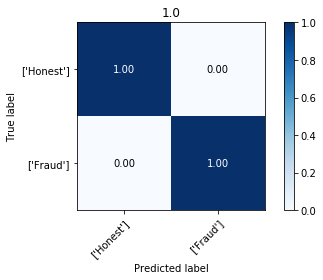

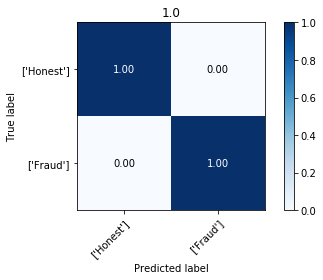

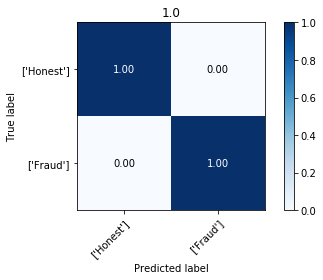

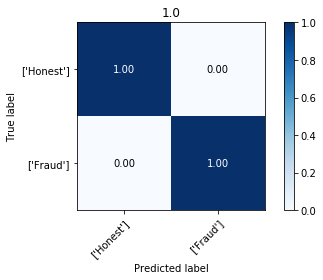

In [22]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [23]:
K.clear_session()

In [24]:
model2 = models.Sequential()
model2.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,),
                        kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(units = 1,activation = 'sigmoid'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


In [25]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model2.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model2.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

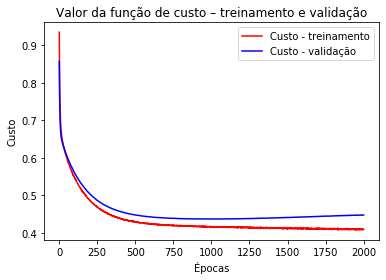

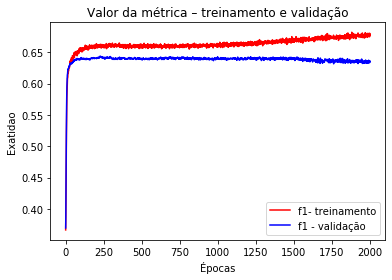

In [26]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [27]:
prob = np.ravel(model2.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.46071380105848825, 0.516340897471192, 0.5648865213304087, 0.6096628082536487, 0.6513216845878136, 0.6879286694101509, 0.721165156022971, 0.7521157101092476, 0.7828674948240165, 0.8114991317769632, 0.8376439904368616, 0.8564331843020367, 0.8791773778920309, 0.9034552845528455, 0.9243979057591623, 0.9435059540293548, 0.9685774946921444, 0.9878048780487805]
recall values: [0.9604639649197256, 0.9285663766885919, 0.8924959332343164, 0.8567791215786124, 0.8225475634769078, 0.7803239267274913, 0.7371808473017893, 0.6914208925666596, 0.6418417144069595, 0.5949501379164014, 0.5451587806775585, 0.4877289765895749, 0.43539147040101844, 0.3772544027158922, 0.31218615177876796, 0.2409647075465026, 0.16132682650823962, 0.07447485677912158]
f1 values: [0.6227215407543276, 0.6636506091088308, 0.6918690717692857, 0.712399658913817, 0.7269885919674949, 0.7312191404049442, 0.7290850587576945, 0.720492316763091, 0.7053748396875363, 0.6865537645378493, 0.6604687031403966, 0.6215132260

Normalized confusion matrix
[[0.49395136 0.50604864]
 [0.03953604 0.96046396]]
Normalized confusion matrix
[[0.60849357 0.39150643]
 [0.07143362 0.92856638]]
Normalized confusion matrix
[[0.69056412 0.30943588]
 [0.10750407 0.89249593]]
Normalized confusion matrix
[[0.75308799 0.24691201]
 [0.14322088 0.85677912]]
Normalized confusion matrix
[[0.80179549 0.19820451]
 [0.17745244 0.82254756]]
Normalized confusion matrix
[[0.84066599 0.15933401]
 [0.21967607 0.78032393]]
Normalized confusion matrix
[[0.87170508 0.12829492]
 [0.26281915 0.73718085]]
Normalized confusion matrix
[[0.89742773 0.10257227]
 [0.30857911 0.69142089]]
Normalized confusion matrix
[[0.91987139 0.08012861]
 [0.35815829 0.64184171]]
Normalized confusion matrix
[[0.93779447 0.06220553]
 [0.40504986 0.59495014]]
Normalized confusion matrix
[[0.95243856 0.04756144]
 [0.45484122 0.54515878]]
Normalized confusion matrix
[[0.96319878 0.03680122]
 [0.51227102 0.48772898]]
Normalized confusion matrix
[[0.97306762 0.02693238]

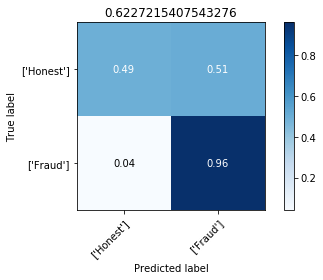

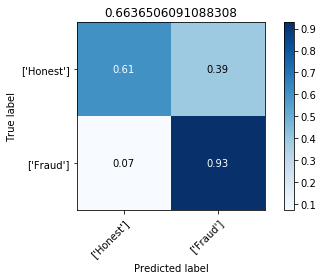

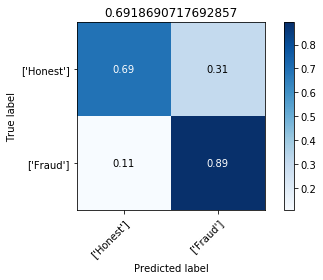

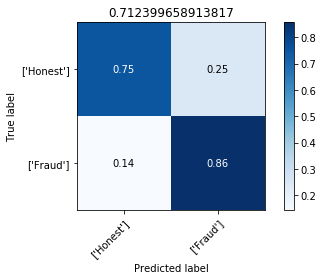

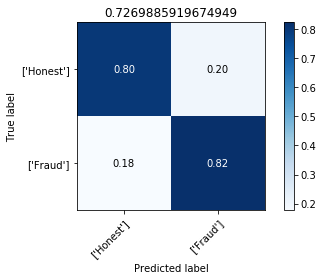

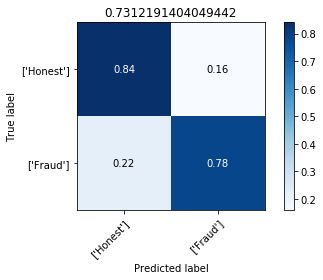

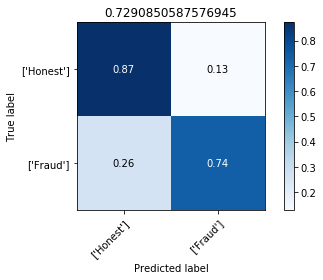

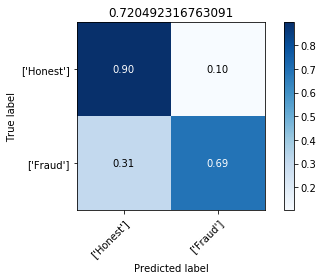

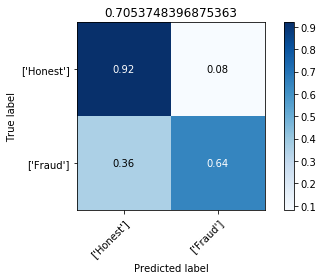

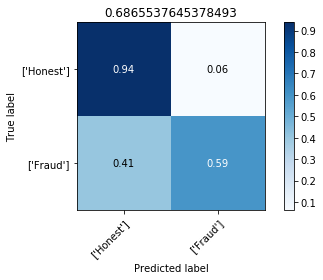

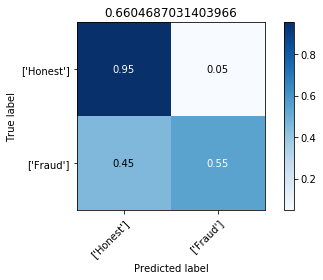

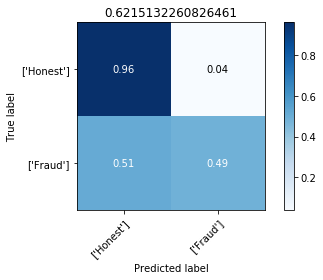

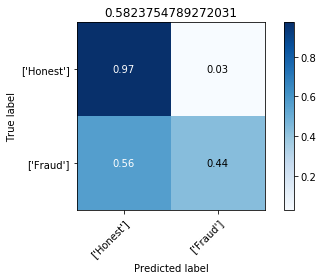

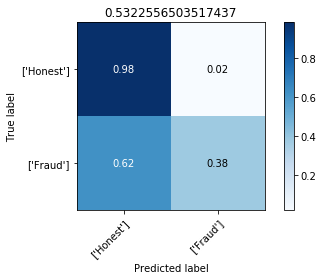

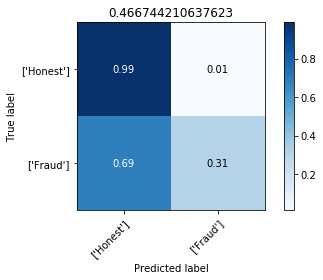

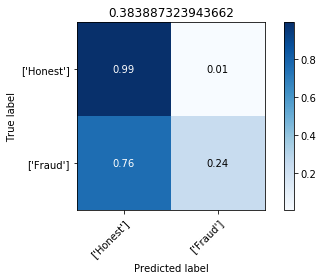

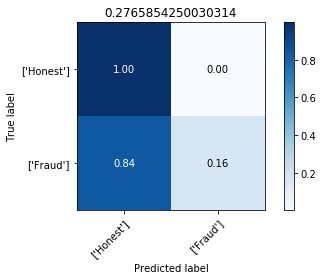

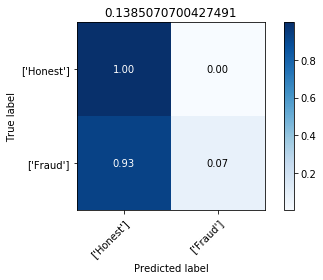

In [28]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [29]:
K.clear_session()

In [30]:
model3 = models.Sequential()
model3.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model3.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.01)))
BatchNormalization(axis=1)
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(units = 1,activation = 'sigmoid'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


In [31]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model3.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model3.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

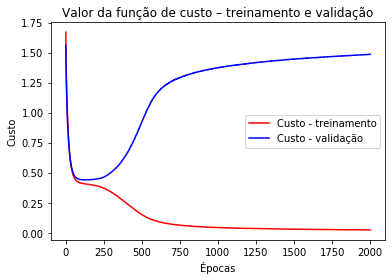

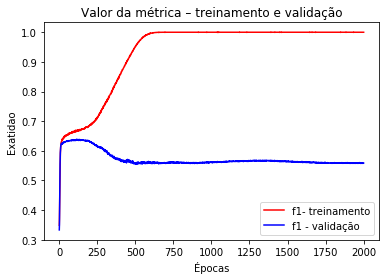

In [32]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [33]:
prob = np.ravel(model3.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9756701322582927]
f1 values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9876852581083984]


Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1.         0.        ]
 [0.02432987 0.97567013]]


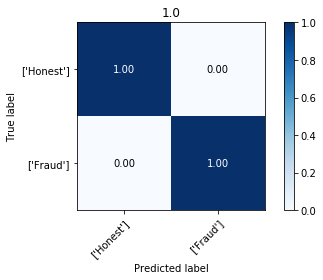

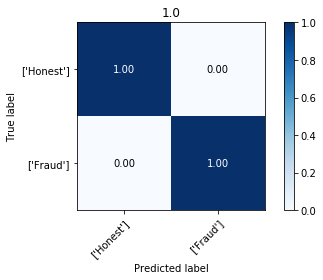

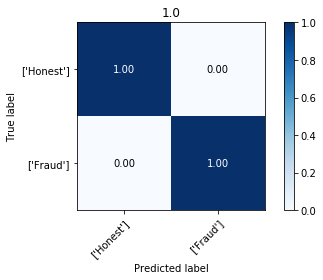

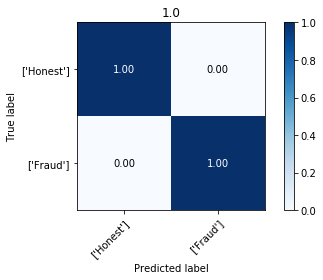

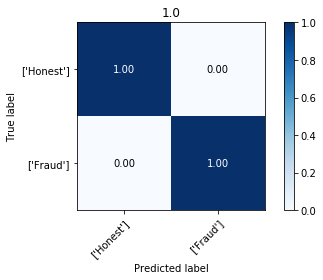

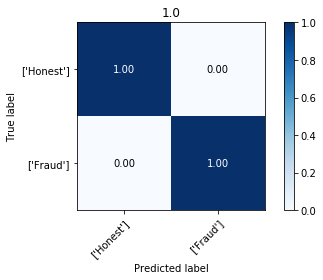

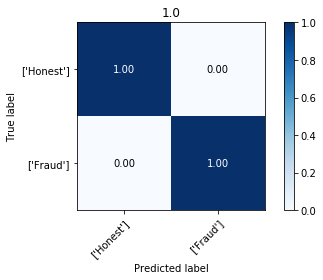

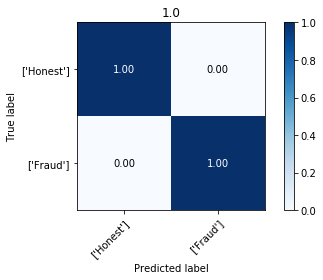

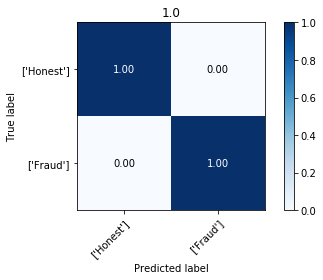

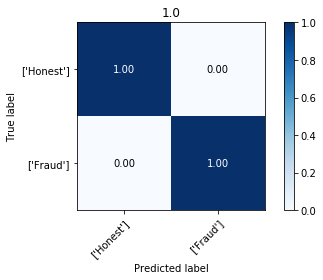

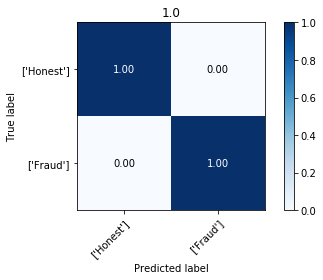

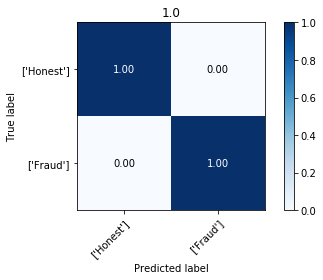

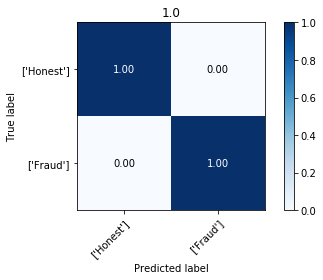

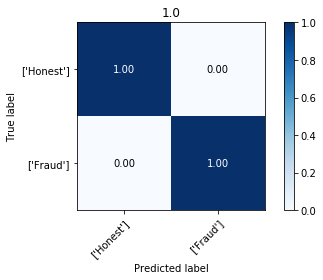

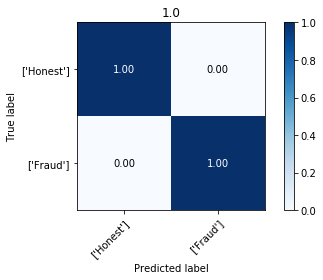

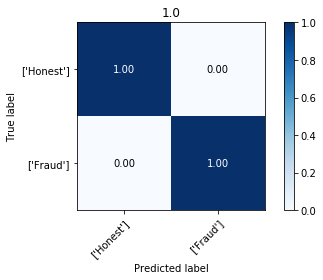

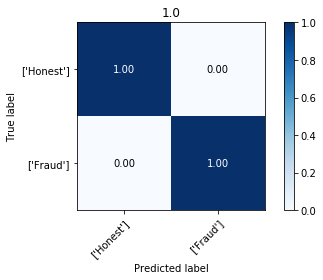

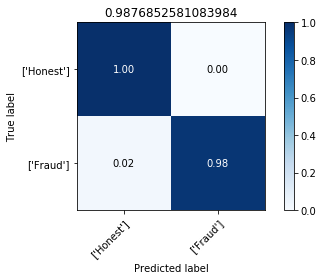

In [34]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [35]:
K.clear_session()

In [36]:
model4 = models.Sequential()
model4.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model4.add(layers.Dropout(0.1))
model4.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.01)))
BatchNormalization(axis=1)
model4.add(layers.Dropout(0.3))
model4.add(layers.Dense(units = 1,activation = 'sigmoid'))
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


In [37]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model4.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model4.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

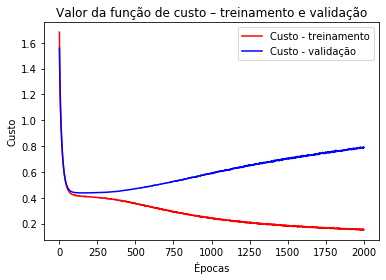

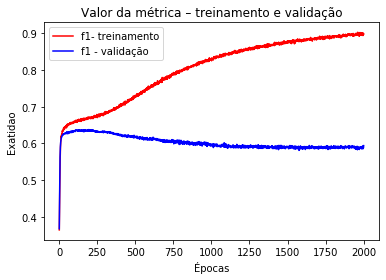

In [38]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [39]:
prob = np.ravel(model4.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.8239682909769177, 0.885352712692645, 0.9231272489368663, 0.9482712229247948, 0.9657158529895776, 0.9763642683350713, 0.9837032874402922, 0.9890880748246298, 0.9914981781810388, 0.9942968524400808, 0.995833637891967, 0.9971826809015422, 0.998332196194375, 0.9988314116547211, 0.9994324170923539, 0.999827882960413, 1.0, 1.0]
recall values: [0.9997878209208572, 0.9995049154820002, 0.9979489355682863, 0.9970294928920008, 0.9961100502157154, 0.9933517221868591, 0.9904519414385742, 0.9872692552514322, 0.9815404201145767, 0.9741141523445789, 0.9635759247471533, 0.9512695381568711, 0.9313954310771625, 0.9067826578965981, 0.8717731098380367, 0.8216988471603367, 0.7385246481363604, 0.5950208642761157]
f1 values: [0.9034030995366671, 0.9389721271718547, 0.9590810222947254, 0.9720393035683502, 0.9806775058315637, 0.9847847426728369, 0.9870660792951542, 0.9881778281183633, 0.9864941711686096, 0.984102032796256, 0.9794392523364487, 0.9736851630651175, 0.9637028905964141, 0.950583

Normalized confusion matrix
[[9.03858398e-01 9.61416019e-02]
 [2.12179079e-04 9.99787821e-01]]
Normalized confusion matrix
[[9.41742009e-01 5.82579906e-02]
 [4.95084518e-04 9.99504915e-01]]
Normalized confusion matrix
[[0.96259391 0.03740609]
 [0.00205106 0.99794894]]
Normalized confusion matrix
[[0.97551891 0.02448109]
 [0.00297051 0.99702949]]
Normalized confusion matrix
[[0.98408252 0.01591748]
 [0.00388995 0.99611005]]
Normalized confusion matrix
[[0.98917611 0.01082389]
 [0.00664828 0.99335172]]
Normalized confusion matrix
[[0.99261429 0.00738571]
 [0.00954806 0.99045194]]
Normalized confusion matrix
[[0.99509742 0.00490258]
 [0.01273074 0.98726926]]
Normalized confusion matrix
[[0.99621164 0.00378836]
 [0.01845958 0.98154042]]
Normalized confusion matrix
[[0.99748504 0.00251496]
 [0.02588585 0.97411415]]
Normalized confusion matrix
[[0.99818541 0.00181459]
 [0.03642408 0.96357592]]
Normalized confusion matrix
[[0.99879027 0.00120973]
 [0.04873046 0.95126954]]
Normalized confusion

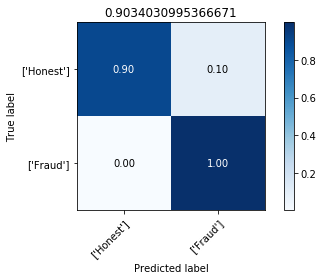

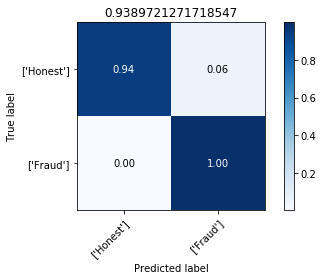

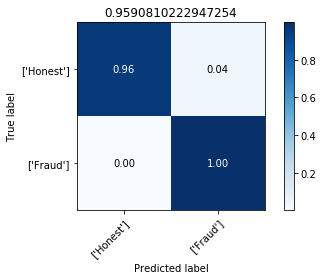

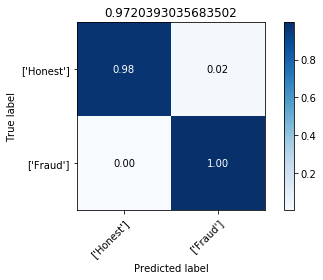

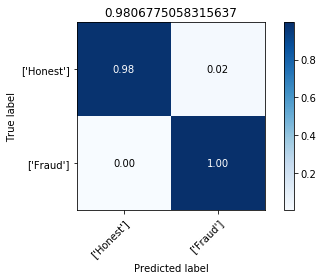

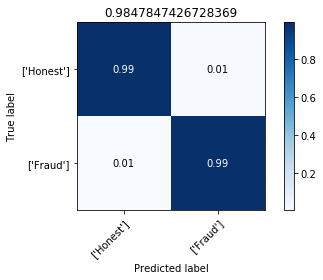

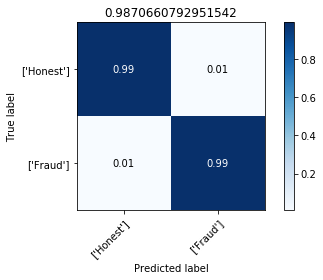

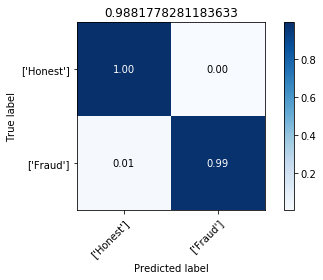

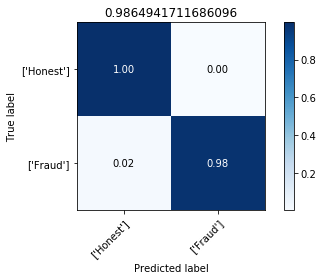

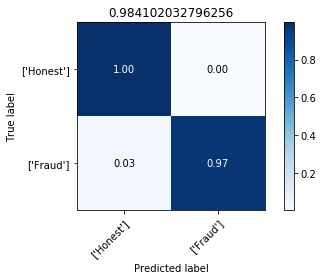

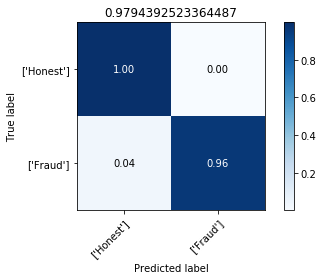

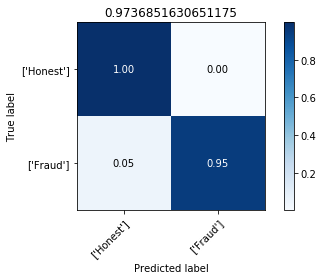

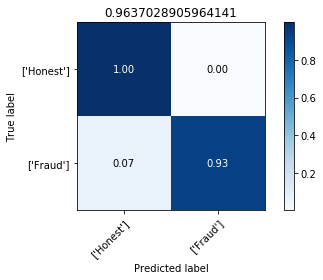

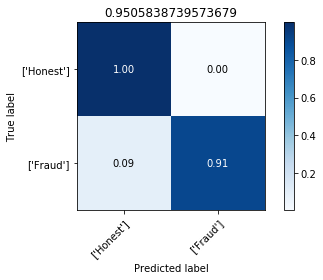

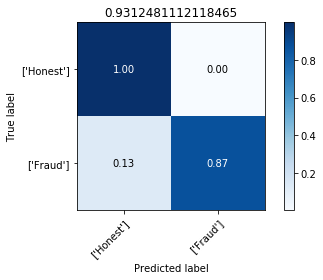

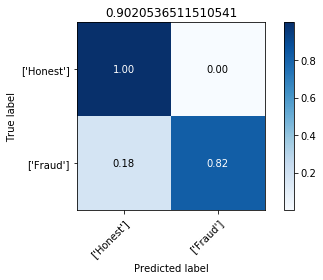

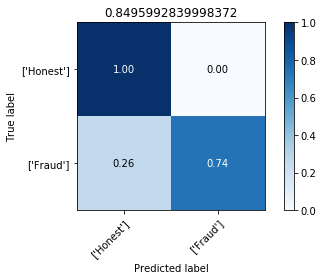

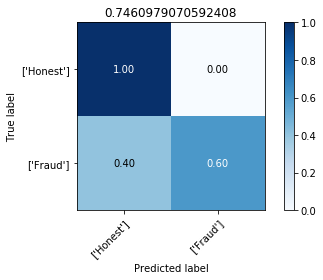

In [40]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [41]:
K.clear_session()

In [42]:
model5 = models.Sequential()
model5.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model5.add(layers.Dropout(0.2))
model5.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.01)))
BatchNormalization(axis=1)
model5.add(layers.Dropout(0.3))
model5.add(layers.Dense(units = 1,activation = 'sigmoid'))
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


In [43]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model5.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model5.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

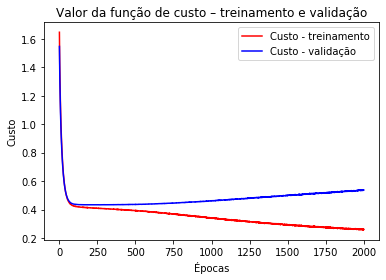

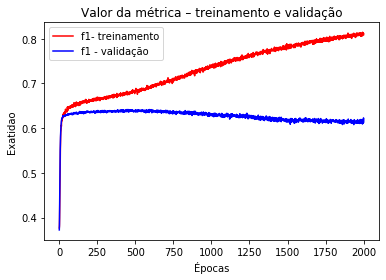

In [44]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [45]:
prob = np.ravel(model5.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.6394595088103716, 0.7149388677694442, 0.774179062587707, 0.8192358524570468, 0.8542672085344171, 0.8842070116861436, 0.908631933244513, 0.9286761471924938, 0.9456330036040181, 0.9587462734670856, 0.9672674715184493, 0.9758698599186625, 0.9823865285976967, 0.9877332774166492, 0.9925119925119925, 0.9946764946764947, 0.9974155754651964, 0.9986938349007315]
recall values: [0.9907348468774312, 0.9842987481434331, 0.9754579531791499, 0.9644953674234387, 0.9514817172360138, 0.9364877289765896, 0.9164721691774524, 0.8960322512200297, 0.8721974679963223, 0.8415729542400453, 0.8046537944691987, 0.763703232194639, 0.7179432774595091, 0.6663130348680953, 0.5999717094561143, 0.5153829832378527, 0.40943489638588304, 0.27038687318763704]
f1 values: [0.7772506588985991, 0.8282696027376878, 0.8632409088064092, 0.8859509501380544, 0.9002576370997423, 0.9095967575736759, 0.9125352112676056, 0.912062200784709, 0.9074319352465049, 0.896346516007533, 0.878498899656384, 0.856848119346135

Normalized confusion matrix
[[0.74856743 0.25143257]
 [0.00926515 0.99073485]]
Normalized confusion matrix
[[0.82334777 0.17665223]
 [0.01570125 0.98429875]]
Normalized confusion matrix
[[0.87192793 0.12807207]
 [0.02454205 0.97545795]]
Normalized confusion matrix
[[0.90420858 0.09579142]
 [0.03550463 0.96449537]]
Normalized confusion matrix
[[0.92693875 0.07306125]
 [0.04851828 0.95148172]]
Normalized confusion matrix
[[0.94479817 0.05520183]
 [0.06351227 0.93648773]]
Normalized confusion matrix
[[0.95851904 0.04148096]
 [0.08352783 0.91647217]]
Normalized confusion matrix
[[0.96902458 0.03097542]
 [0.10396775 0.89603225]]
Normalized confusion matrix
[[0.97742901 0.02257099]
 [0.12780253 0.87219747]]
Normalized confusion matrix
[[0.9837005  0.0162995 ]
 [0.15842705 0.84157295]]
Normalized confusion matrix
[[0.98774354 0.01225646]
 [0.19534621 0.80465379]]
Normalized confusion matrix
[[0.99150006 0.00849994]
 [0.23629677 0.76370323]]
Normalized confusion matrix
[[0.99420604 0.00579396]

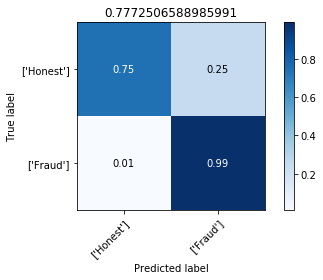

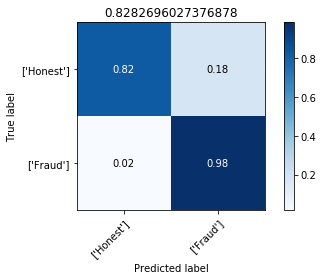

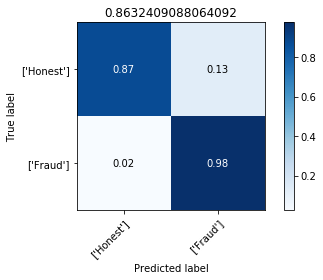

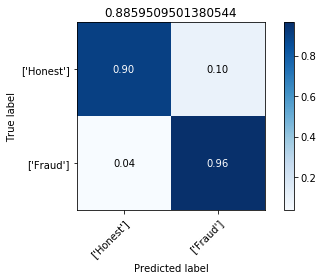

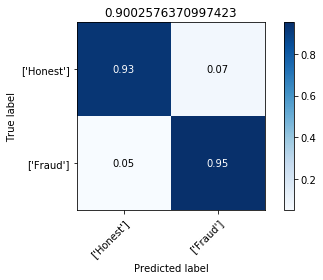

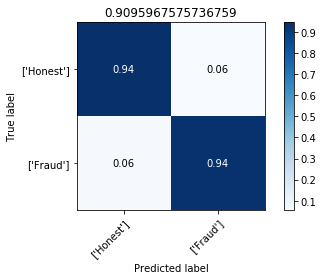

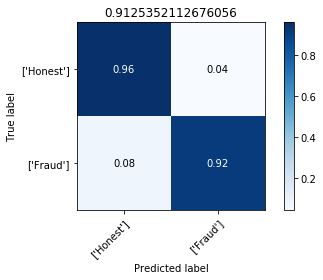

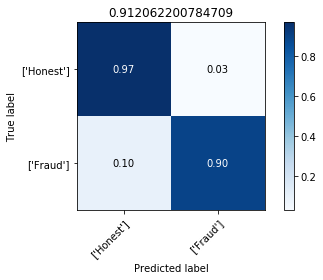

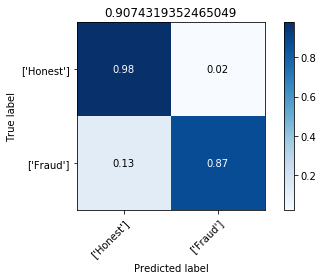

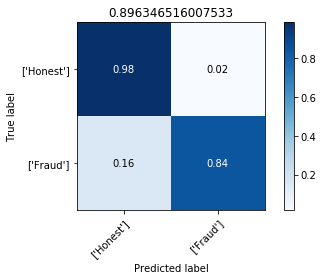

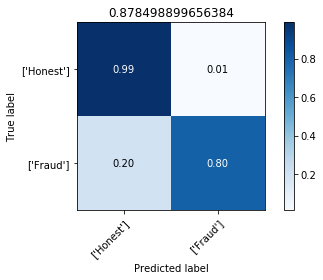

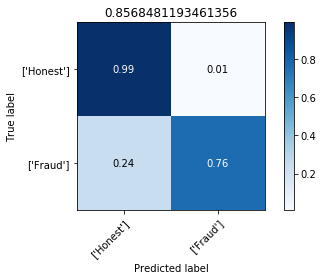

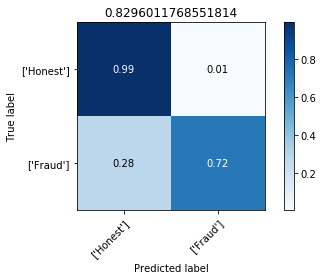

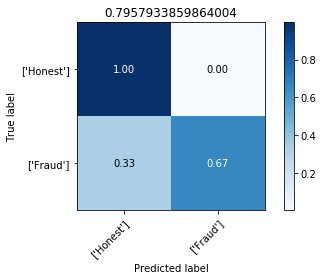

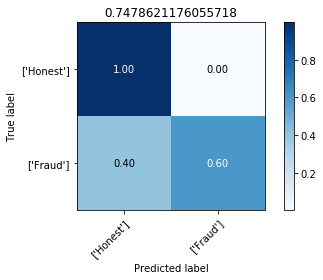

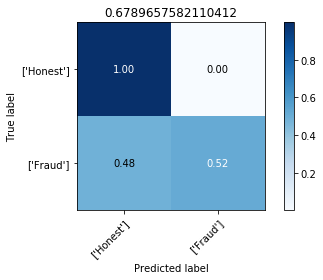

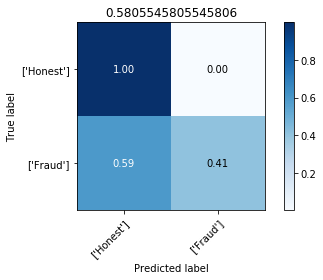

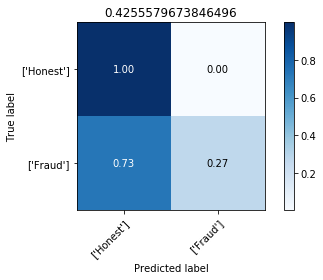

In [46]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [47]:
K.clear_session()

In [48]:
model6 = models.Sequential()
model6.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model6.add(layers.Dropout(0.2))
model6.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
BatchNormalization(axis=1)
model6.add(layers.Dropout(0.3))
model6.add(layers.Dense(units = 1,activation = 'sigmoid'))
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


In [49]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model6.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model6.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

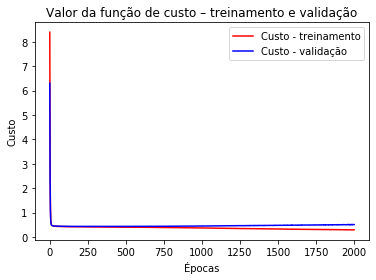

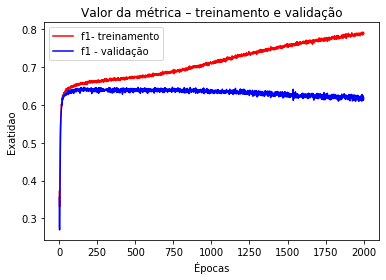

In [50]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [51]:
prob = np.ravel(model6.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.5778523768079904, 0.6484896960572127, 0.7078932306571621, 0.7578726778432261, 0.8009507557289127, 0.8360421271616175, 0.8629948364888124, 0.8890761227928786, 0.9116503344221496, 0.9308862433862434, 0.9455926514750044, 0.9562535585500095, 0.9669266770670827, 0.9750869061413673, 0.9828155981493721, 0.9912974683544303, 0.9943808532778355, 0.9982847341337907]
recall values: [0.9861376334960039, 0.9748214159417214, 0.9622321239125822, 0.9463894193365867, 0.9294858193648773, 0.9095409859254544, 0.8865549190183182, 0.8582643751326119, 0.8290543885706203, 0.7963788103826296, 0.7571964071009265, 0.7127095268406535, 0.6575429662635264, 0.5951623169955442, 0.525850484475564, 0.4431006436098734, 0.3379305467147606, 0.20581370676851263]
f1 values: [0.7287028326539144, 0.778854575763569, 0.8156963846753401, 0.8417046705456832, 0.8604445608406718, 0.8712441990447478, 0.8746162433714764, 0.8733985893191306, 0.86839278438345, 0.8583952734896131, 0.8409724676956915, 0.81671191798030

Normalized confusion matrix
[[0.67572902 0.32427098]
 [0.01386237 0.98613763]]
Normalized confusion matrix
[[0.76216096 0.23783904]
 [0.02517858 0.97482142]]
Normalized confusion matrix
[[0.82127849 0.17872151]
 [0.03776788 0.96223212]]
Normalized confusion matrix
[[0.86390551 0.13609449]
 [0.05361058 0.94638942]]
Normalized confusion matrix
[[0.896027   0.103973  ]
 [0.07051418 0.92948582]]
Normalized confusion matrix
[[0.91971221 0.08028779]
 [0.09045901 0.90954099]]
Normalized confusion matrix
[[0.93664841 0.06335159]
 [0.11344508 0.88655492]]
Normalized confusion matrix
[[0.95180186 0.04819814]
 [0.14173562 0.85826438]]
Normalized confusion matrix
[[0.96383548 0.03616452]
 [0.17094561 0.82905439]]
Normalized confusion matrix
[[0.97338597 0.02661403]
 [0.20362119 0.79637881]]
Normalized confusion matrix
[[0.98038966 0.01961034]
 [0.24280359 0.75719641]]
Normalized confusion matrix
[[0.98532408 0.01467592]
 [0.28729047 0.71270953]]
Normalized confusion matrix
[[0.98987648 0.01012352]

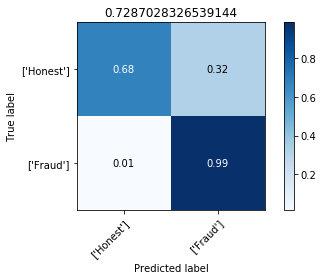

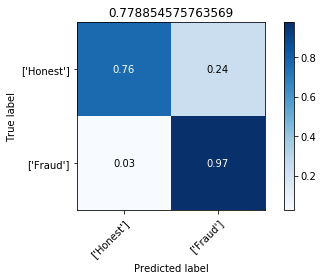

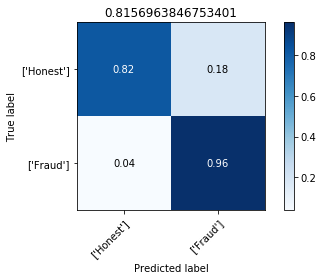

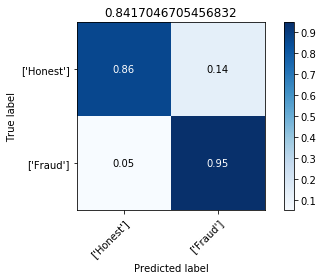

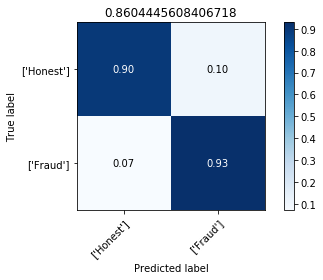

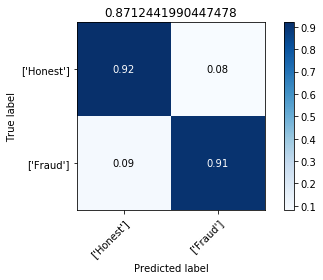

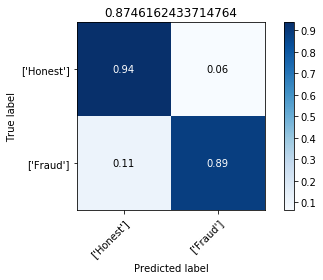

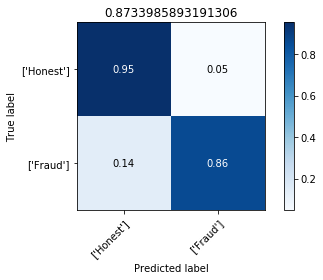

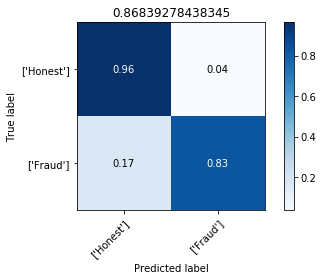

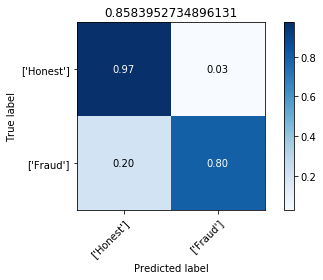

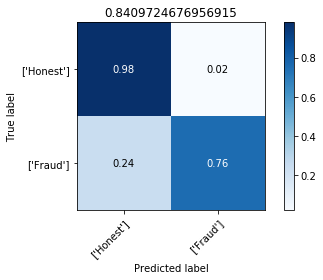

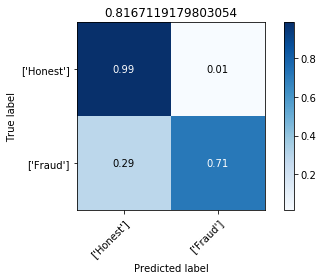

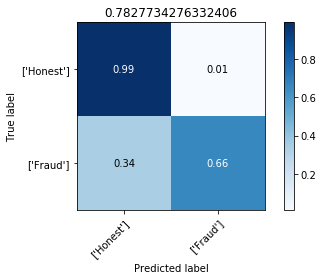

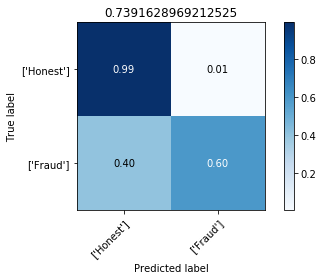

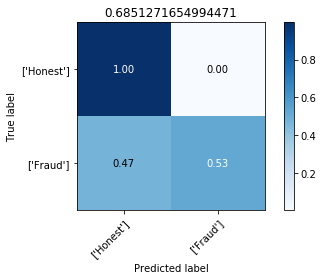

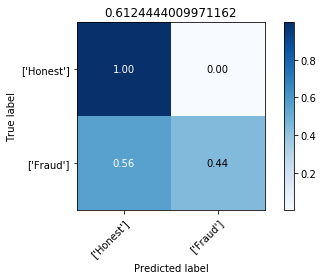

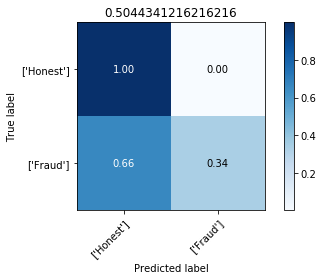

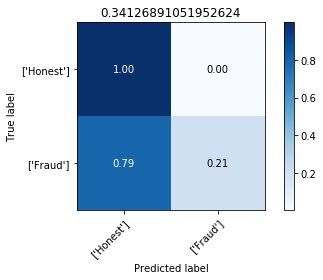

In [52]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)